# Entrenamiento y Test

## 1. Imports y librerías

In [1]:
!pip install numpy
!pip install pandas
!pip install datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import joblib
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer
from transformers.training_args import TrainingArguments
from datasets import Dataset, ClassLabel
import nltk
nltk.download('punkt')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## 2. Descarga

In [2]:
data = pd.read_csv("processed_video_games_reviews.csv")
data.dropna(inplace=True)
X = data['reviewText_clean']
y = data['target']

In [3]:
data_nsw = pd.read_csv("processed_video_games_reviews_nsw.csv")
data_nsw.dropna(inplace=True)
X_nsw = data_nsw['reviewText_clean_nsw']
y_nsw = data_nsw['target']

## 3 Approaches
Intentaré 3 aproaches distintos el tercero es el que menos domino pero igual lo queiro intentar.

### 3.1 Logistic Regresion con TF-IDF

In [4]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [5]:
# Vectorizer
tfidf = TfidfVectorizer(
    ngram_range=(1,3),        # Unigrams y bigrams
    min_df=2,                 # Ignorar términos que aparecen en menos de 3 documentos
    max_df=0.70,              # Ignorar los que aparecen en más del 85% (palabras demasiado comunes)
    max_features=15000        # Limita la dimensionalidad (ajustable)
)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [6]:
# Modelo
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)

              precision    recall  f1-score   support

           0       0.87      0.13      0.23       245
           1       0.78      0.99      0.87       755

    accuracy                           0.78      1000
   macro avg       0.82      0.56      0.55      1000
weighted avg       0.80      0.78      0.72      1000

Accuracy: 0.783


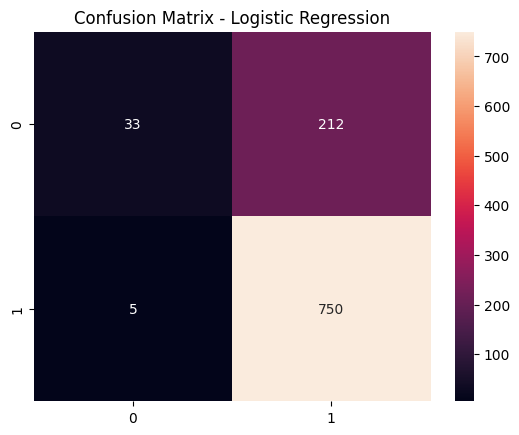

In [7]:
# Métricas
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

In [8]:
# Guardado del modelo y vectorizador
joblib.dump(lr_model, 'model_logreg_tfidf.pkl')
joblib.dump(tfidf, 'vectorizer_tfidf.pkl')

['vectorizer_tfidf.pkl']

En mi primer intento obtuve un accuracy de 0.761. Luego forcé el uso de unigramas y bigramas mediante el ajuste de los parámetros, lo que me permitió aumentarlo a 0.78. Al incluir trigramas, el incremento fue marginal, alcanzando 0.783. He seguido experimentando con otros parámetros, pero no he observado mejoras significativas en el rendimiento.


### 3.2 Naive Bayes con One-hot

In [9]:
# Vectorizer con CountVectorizer sin stopwords (ya las quitamos antes)
count_vect = CountVectorizer(binary=True)
X_train_oh = count_vect.fit_transform(X_train)
X_test_oh = count_vect.transform(X_test)

In [10]:
# Modelo
nb_model = MultinomialNB(alpha=0.6, class_prior=[0.4,0.6])
nb_model.fit(X_train_oh, y_train)
y_pred_nb = nb_model.predict(X_test_oh)

              precision    recall  f1-score   support

           0       0.72      0.23      0.35       245
           1       0.80      0.97      0.87       755

    accuracy                           0.79      1000
   macro avg       0.76      0.60      0.61      1000
weighted avg       0.78      0.79      0.74      1000

Accuracy: 0.789


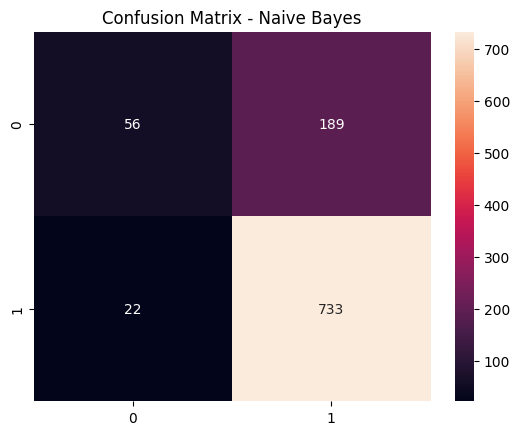

In [11]:
# Métricas
print(classification_report(y_test, y_pred_nb))
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt='d')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

In [12]:
# Guardado del modelo y vectorizador
joblib.dump(nb_model, 'model_nb_onehot.pkl')
joblib.dump(count_vect, 'vectorizer_onehot.pkl')

['vectorizer_onehot.pkl']

En mi primer intento obtuve un accuracy de 0.76. Empecé a ajustar el parámetro alpha para mejorarlo, pero noté que al hacerlo aumentaba la precisión sobre la clase mayoritaria (1 o sentimiento positivo), mientras que empeoraba notablemente en la clase desbalanceada (0 o sentimiento negativo), incrementando los falsos positivos. Investigando un poco más, vi que podía ajustar class_prior y, efectivamente, logré subir el accuracy a 0.789 sin comprometer tanto la precisión sobre los falsos negativos. Me gustaría contar con más tiempo para experimentar otras aproximaciones; lo primero que cambiaría sería dejar de usar codificación one-hot. Sin embargo, decidí mantenerla por ahora, en parte para explorar algo distinto y tener una base clara desde la cual comparar con los otros modelos.

### 3.3 Bert

In [ ]:
# Preparar datos en formato HuggingFace
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [6]:
def tokenize_bert(example):
    return bert_tokenizer(example['reviewText_clean_nsw'], truncation=True, padding='max_length', max_length=128)


In [ ]:
from datasets import ClassLabel
dataset = Dataset.from_pandas(data_nsw)
dataset = dataset.cast_column("target", ClassLabel(num_classes=2, names=["negative", "positive"]))
dataset = dataset.train_test_split(test_size=0.2, stratify_by_column='target', seed=42)
dataset = dataset.map(tokenize_bert, batched=True)
dataset = dataset.rename_column("target", "labels")

In [ ]:
# Cargar modelo BERT
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

In [9]:
# Entrenamiento
# Ajuste para evitar integración con wandb y error de pérdida
from transformers import DefaultDataCollator
import os
os.environ["WANDB_DISABLED"] = "true"

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="no",
    load_best_model_at_end=False,
    disable_tqdm=True,
    report_to="none"
)

trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    data_collator=DefaultDataCollator(),
    compute_metrics=None
)

trainer.train()

{'loss': 0.5882, 'grad_norm': 2.4379029273986816, 'learning_rate': 4.91e-05, 'epoch': 0.04}
{'loss': 0.5214, 'grad_norm': 4.276220798492432, 'learning_rate': 4.8100000000000004e-05, 'epoch': 0.08}
{'loss': 0.5178, 'grad_norm': 1.4776734113693237, 'learning_rate': 4.71e-05, 'epoch': 0.12}
{'loss': 0.5381, 'grad_norm': 5.64410400390625, 'learning_rate': 4.61e-05, 'epoch': 0.16}
{'loss': 0.4911, 'grad_norm': 3.5445010662078857, 'learning_rate': 4.5100000000000005e-05, 'epoch': 0.2}
{'loss': 0.4234, 'grad_norm': 6.530026912689209, 'learning_rate': 4.41e-05, 'epoch': 0.24}
{'loss': 0.4498, 'grad_norm': 6.073476791381836, 'learning_rate': 4.3100000000000004e-05, 'epoch': 0.28}
{'loss': 0.4031, 'grad_norm': 3.6578903198242188, 'learning_rate': 4.21e-05, 'epoch': 0.32}
{'loss': 0.3955, 'grad_norm': 6.333266258239746, 'learning_rate': 4.11e-05, 'epoch': 0.36}
{'loss': 0.364, 'grad_norm': 7.045213222503662, 'learning_rate': 4.0100000000000006e-05, 'epoch': 0.4}
{'loss': 0.4705, 'grad_norm': 3.74

TrainOutput(global_step=500, training_loss=0.32922383785247805, metrics={'train_runtime': 168.6054, 'train_samples_per_second': 47.436, 'train_steps_per_second': 2.966, 'train_loss': 0.32922383785247805, 'epoch': 2.0})

In [10]:
# Evaluación
bert_eval = trainer.evaluate()
print("Accuracy BERT:", bert_eval['eval_loss'])  # Nota: en este caso se muestra loss como referencia

{'eval_loss': 0.47320935130119324, 'eval_runtime': 6.3313, 'eval_samples_per_second': 157.945, 'eval_steps_per_second': 2.527, 'epoch': 2.0}
Accuracy BERT: 0.47320935130119324


In [11]:
# Guardado del modelo y tokenizer
bert_model.save_pretrained("bert_model_sentiment")
bert_tokenizer.save_pretrained("bert_model_sentiment")

('bert_model_sentiment/tokenizer_config.json',
 'bert_model_sentiment/special_tokens_map.json',
 'bert_model_sentiment/vocab.txt',
 'bert_model_sentiment/added_tokens.json')

## 4. Comentarios y conclusiones

Aqui van mis comentarios.
{'eval_loss': 0.4093605577945709, 'eval_runtime': 398.8172, 'eval_samples_per_second': 2.507, 'eval_steps_per_second': 0.04, 'epoch': 2.0}
Accuracy BERT: 0.4093605577945709